In [99]:
from pandas_datareader import data as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

start_date = '2024-05-01'
end_date = '2024-08-14'

zgpa = yf.download('2330.TW',start_date,end_date)
zgpa.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-02,789.0,789.0,772.0,772.0,769.027649,40527228
2024-05-03,788.0,788.0,773.0,780.0,776.996887,29901556
2024-05-06,791.0,793.0,786.0,786.0,782.973755,32599878
2024-05-07,797.0,800.0,792.0,800.0,796.919861,33890214
2024-05-08,794.0,802.0,792.0,802.0,798.912170,21757193


In [100]:
zgpa_signal = pd.DataFrame(index=zgpa.index)
zgpa_signal['price'] = zgpa['Adj Close']

# 計算差異，確保 'diff' 是數值
zgpa_signal['diff'] = zgpa_signal['price'].diff()

# 用 0.0 填充缺失值
zgpa_signal = zgpa_signal.fillna(0.0)

# 檢查 'diff' 的值類型，並生成 'signal'
zgpa_signal['signal'] = np.where(zgpa_signal['diff'] >= 0, 0, 1)

# 計算 'order'，確保差異計算正確
zgpa_signal['order'] = zgpa_signal['signal'].diff() * 100

zgpa_signal.head()


,price,diff,signal,order
Date,,,,
2024-05-02,769.027649,0.000000,0,NaN
2024-05-03,776.996887,7.969238,0,0.0
2024-05-06,782.973755,5.976868,0,0.0
2024-05-07,796.919861,13.946106,0,0.0
2024-05-08,798.912170,1.992310,0,0.0


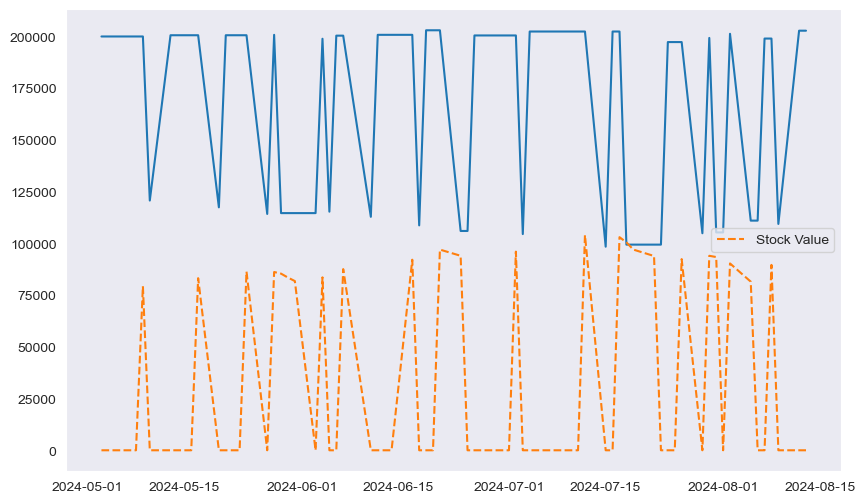

In [101]:
initial_cash = 200000

zgpa_signal['stock']=zgpa_signal['order']*zgpa_signal['price']
zgpa_signal['cash'] = initial_cash - zgpa_signal['stock'].cumsum()
zgpa_signal['total'] = zgpa_signal['stock']+zgpa_signal['cash']
plt.figure(figsize=(10,6))
plt.plot(zgpa_signal['total'])
plt.plot(zgpa_signal['order'].cumsum()*zgpa_signal['price'], '--', label = 'Stock Value')
plt.grid()
plt.legend(loc = 'center right')
plt.show()

In [102]:
#这里使用10日均线
period = 10
#设置一个空列表，用来存储每10天的价格
avg_10 = []
#再设置一个空列表，用来存储每10天价格的均值
avg_value = []
#设置一个循环
for price in zgpa['Adj Close']:
    #把每天的价格传入到avg_10列表
    avg_10.append(price)
    #当列表中存储的数值多于10个时
    if len(avg_10) > period:
        #就把前面传入的价格数据删掉，确保列表中只有10天的数据
        del avg_10[0]
    #将10天数据的均值传入到avg_value列表中
    avg_value.append(np.mean(avg_10))
#把计算好的10日均价写到股票价格数据表中
zgpa = zgpa.assign(avg_10 = pd.Series(avg_value, index = zgpa.index))
#检查一下是否添加成功
zgpa.head()
    

,Open,High,Low,Close,Adj Close,Volume,avg_10
Date,,,,,,,
2024-05-02,789.0,789.0,772.0,772.0,769.027649,40527228,769.027649
2024-05-03,788.0,788.0,773.0,780.0,776.996887,29901556,773.012268
2024-05-06,791.0,793.0,786.0,786.0,782.973755,32599878,776.332764
2024-05-07,797.0,800.0,792.0,800.0,796.919861,33890214,781.479538
2024-05-08,794.0,802.0,792.0,802.0,798.912170,21757193,784.966064


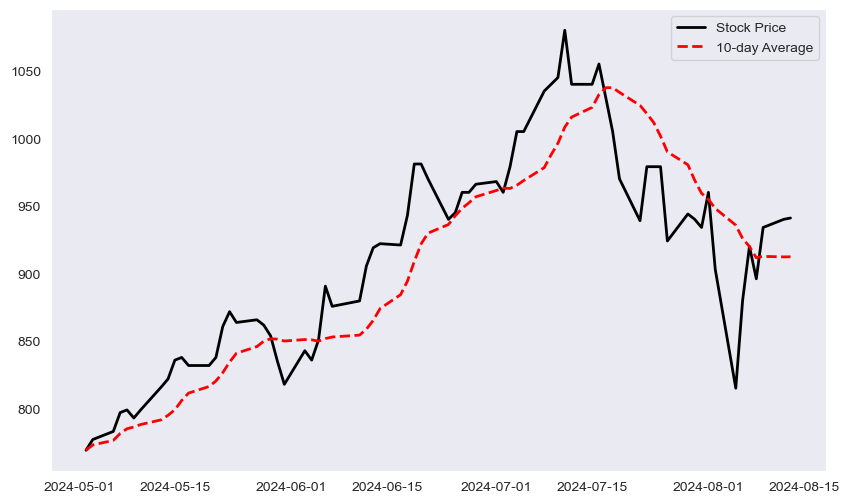

In [103]:
# 設定图像尺寸10*6
plt.figure(figsize=(10,6))
# 繪製股價變化
plt.plot(zgpa['Adj Close'], lw =2, color='k', label = 'Stock Price')
# 繪製10日均線
plt.plot(zgpa['avg_10'],'--', lw = 2, color='r', label = '10-day Average')
# 添加圖著跟网格
plt.legend()
plt.grid()
# 將图像進行显示
plt.show()

In [104]:
# 新建一個數據表， 命名為strategy
# 序號與原始數據保持一致
strategy = pd.DataFrame(index=zgpa.index)
# 添加一個signal字段，用來儲存交易信号
strategy['signal'] = 0
# 將5日均價保存到avg_5這個字段
strategy['avg_5'] = zgpa['Adj Close'].rolling(window=5).mean()
# 將10日均價保存到avg_10這個字段
strategy['avg_10'] = zgpa['Adj Close'].rolling(window=10).mean()
# 當5日均價大於10日均價標記為1， 反之為0
strategy['signal']=np.where(strategy['avg_5'] > strategy['avg_10'],1,0)
# 根據交易信号下單，當信号從0變成1時買入
# 當信号從1變成0時賣出
# 當信号不變時不下單
strategy['order'] = strategy['signal'].diff()
# 查看數據表後10行
strategy.tail(10)   


,signal,avg_5,avg_10,order
Date,,,,
2024-07-31,0,944.2,959.3,0.0
2024-08-01,0,940.4,954.8,0.0
2024-08-02,0,936.2,948.1,0.0
2024-08-05,0,910.4,935.7,0.0
2024-08-06,0,898.4,925.8,0.0
2024-08-07,0,895.6,919.9,0.0
2024-08-08,0,882.8,911.6,0.0
2024-08-09,0,889.0,912.6,0.0
2024-08-12,1,914.0,912.2,1.0


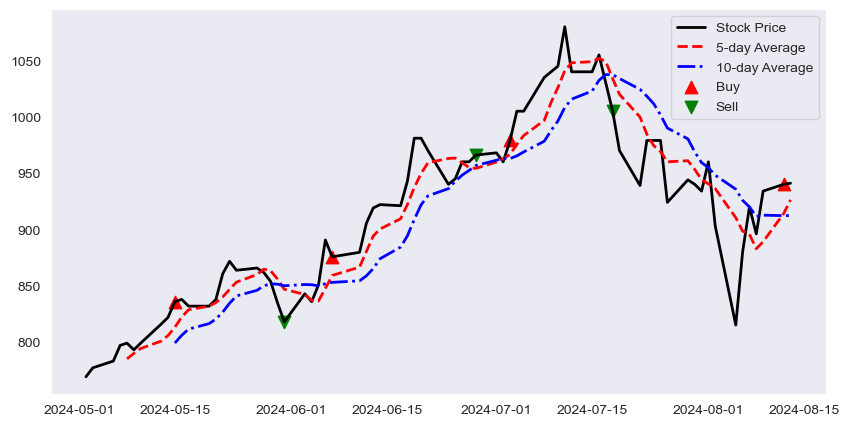

In [105]:
# 創建尺寸10*5的畫布
plt.figure(figsize=(10,5))
# 使用实线繪製股價
plt.plot(zgpa['Adj Close'], lw =2, color='k', label = 'Stock Price')
# 使用虚线繪製5日均線
plt.plot(strategy['avg_5'],'--', lw = 2, color='r', label = '5-day Average')
# 使用-.風格繪製10日均線
plt.plot(strategy['avg_10'],'-.', lw = 2, color='b', label = '10-day Average')
# 將買入信号用正三角標示
plt.scatter(strategy.loc[strategy.order==1].index,
           zgpa['Adj Close'][strategy.order==1],
           marker = '^', s=80,color='r',label='Buy')
# 將賣出信号用倒三角標示
plt.scatter(strategy.loc[strategy.order==-1].index,
           zgpa['Adj Close'][strategy.order==-1],
           marker = 'v', s=80,color='g',label='Sell')
#添加图注
plt.legend()
plt.grid()
plt.show()


In [106]:
# 初始化启动资金
initial_cash = 2000000

# 创建一个空的投资组合数据表，并将 index 设置为与 strategy 一致
portfolio = pd.DataFrame(index=strategy.index)

# 新建一个数据表 positions，序号保持和 strategy 数据表一致，用 0 将空值进行替换
positions = pd.DataFrame(index=strategy.index).fillna(0)

# 设置 stock 字段为交易信号的 1000 倍，因为 A 股买卖都是最低 1000 股
positions['stock'] = strategy['signal'] * 1000

# 创建投资组合数据表，用持仓的股票数量乘以股价得出持仓的股票市值
portfolio['stock value'] = positions.multiply(zgpa['Adj Close'], axis=0)

# 仓位的变化就是下单的数量
order = positions.diff()

# 用初始资金减去下单金额的总和就是剩余的资金
portfolio['cash'] = initial_cash - order.multiply(zgpa['Adj Close'], axis=0).cumsum()

# 剩余的资金 + 持仓股票市值即为总资产
portfolio['total'] = portfolio['cash'] + portfolio['stock value']

# 检查一下后 10 行
portfolio.tail(10)

,stock value,cash,total
Date,,,
2024-07-31,0.0,2.098454e+06,2.098454e+06
2024-08-01,0.0,2.098454e+06,2.098454e+06
2024-08-02,0.0,2.098454e+06,2.098454e+06
2024-08-05,0.0,2.098454e+06,2.098454e+06
2024-08-06,0.0,2.098454e+06,2.098454e+06
2024-08-07,0.0,2.098454e+06,2.098454e+06
2024-08-08,0.0,2.098454e+06,2.098454e+06
2024-08-09,0.0,2.098454e+06,2.098454e+06
2024-08-12,940000.0,1.158454e+06,2.098454e+06


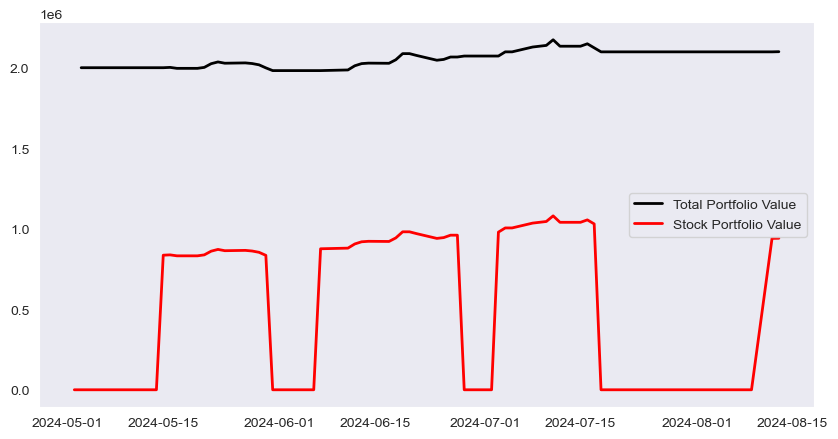

In [107]:
# 創建10*5的畫布
plt.figure(figsize=(10,5))
# 繪製總資產曲线
plt.plot(portfolio['total'], lw =2, color='k', label = 'Total Portfolio Value')
# 繪製股票持倉曲线
plt.plot(portfolio['stock value'], lw =2, color='r', label = 'Stock Portfolio Value')
# 添加圖注、网格、展示图像
plt.legend()
plt.grid()
plt.show()


In [108]:
#创建一个名为turtle的数据表，使用原始数据表的日期序号
turtle = pd.DataFrame(index = zgpa.index)
#设置唐奇安通道的上沿为前5天股价的最高点
turtle['high'] = zgpa['Adj Close'].shift(1).rolling(5).max()
#设置唐奇安通道的下沿为过去5天的最低点
turtle['low'] = zgpa['Adj Close'].shift(1).rolling(5).min()
#当股价突破上沿时，发出买入信号
turtle['buy'] = zgpa['Adj Close'] > turtle['high']
#当股价突破下沿时，发出卖出信号
turtle['sell'] = zgpa['Adj Close'] < turtle['low']
#检查信号创建情况
turtle.tail()

,high,low,buy,sell
Date,,,,
2024-08-07,960.0,815.0,False,False
2024-08-08,960.0,815.0,False,False
2024-08-09,920.0,815.0,True,False
2024-08-12,934.0,815.0,True,False
2024-08-13,940.0,880.0,True,False


In [109]:
#初始的订单状态为0
turtle['orders']=0
#初始的仓位为0
position = 0
#设置循环，遍历turtle数据表
for k in range(len(turtle)):
    #当买入信号为True且仓位为0时下单买入1手
    if turtle.buy[k] and position ==0:
        #修改对应的orders值为1
        turtle.orders.values[k] = 1
        #仓位也增加1手
        position = 1
    #而当卖出信号为True且有持仓时买出1手
    elif turtle.sell[k] and position > 0:
        #orders的值修改为-1
        turtle.orders.values[k] = -1
        #仓位相应清零
        position = 0   
#检查是否成功
turtle.tail(15)

/var/folders/_z/wf028lv51rl4_zw8pxj4k3740000gn/T/ipykernel_87827/2324133629.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if turtle.buy[k] and position ==0:
/var/folders/_z/wf028lv51rl4_zw8pxj4k3740000gn/T/ipykernel_87827/2324133629.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif turtle.sell[k] and position > 0:


,high,low,buy,sell,orders
Date,,,,,
2024-07-24,1030.0,939.0,False,False,0
2024-07-25,1005.0,939.0,False,False,0
2024-07-26,979.0,939.0,False,True,0
2024-07-29,979.0,924.0,False,False,0
2024-07-30,979.0,924.0,False,False,0
2024-07-31,979.0,924.0,False,False,0
2024-08-01,979.0,924.0,False,False,0
2024-08-02,960.0,924.0,False,True,0
2024-08-05,960.0,903.0,False,True,0


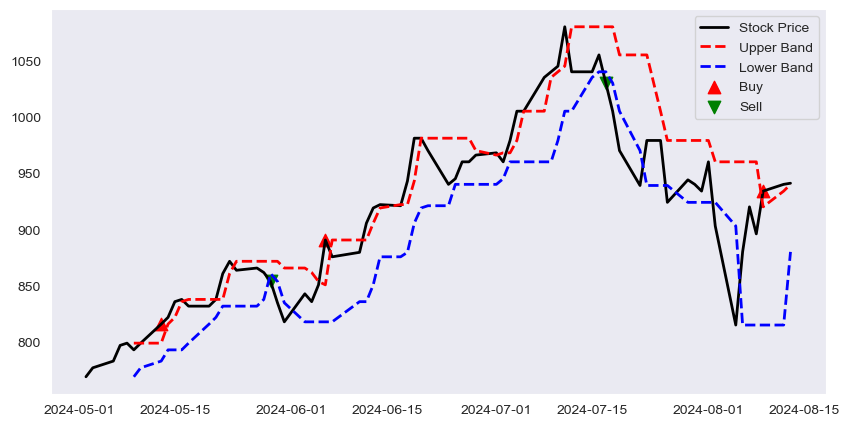

In [110]:
# 繪製一個10*5的畫布
plt.figure(figsize=(10,5))
# 繪製股票折線圖
plt.plot(zgpa['Adj Close'], lw =2, color='k', label = 'Stock Price')
# 繪製唐奇安通道上沿
plt.plot(turtle['high'], lw =2, color='r', ls= '--', label = 'Upper Band')
# 繪製唐奇安通道下沿
plt.plot(turtle['low'], lw =2, color='b', ls= '--', label = 'Lower Band')
# 標示買入訂單，用正三角表示
plt.scatter(turtle.loc[turtle.orders==1].index,
           zgpa['Adj Close'][turtle.orders==1],
           marker = '^', s=80,color='r', label='Buy')
# 標示賣出訂單，用倒三角表示
plt.scatter(turtle.loc[turtle.orders==-1].index,
           zgpa['Adj Close'][turtle.orders==-1],
           marker = 'v', s=80,color='g', label='Sell')
# 添加標注、網格及展示
plt.legend()
plt.grid()
plt.show()



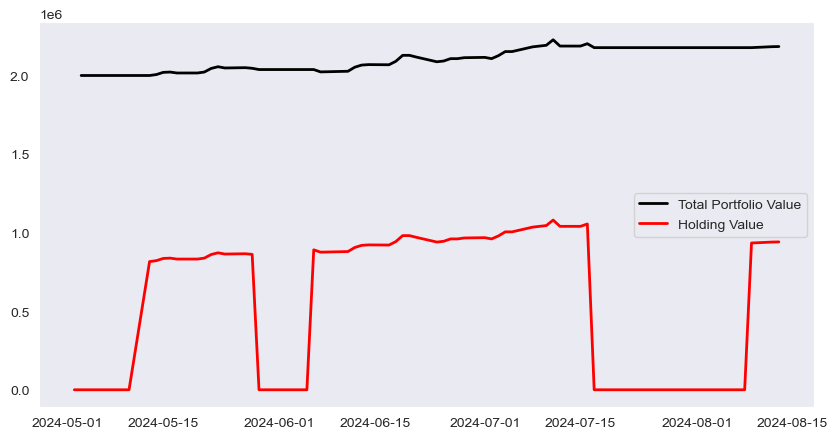

In [111]:
# 再給小瓦兩百萬的啟動資金
initial_cash = 2000000
# 創建新的數據表，序號與turtle相同
positions = pd.DataFrame(index=turtle.index).fillna(0)
# 每次交易為一手，即1000股，倉位即買單及賣單相加合
positions['stock'] = 1000*turtle['orders'].cumsum()
# 創建投資组合數據表
portfolio = positions.multiply(zgpa['Adj Close'], axis=0)
# 持倉市值為持倉股票數乘與股價
portfolio['holding_values'] = (positions.multiply(zgpa['Adj Close'], axis=0))
# 計算倉位變化
pos_diff = positions.diff()
# 剩餘的資金是出始資金減去倉位變化產生的現金流累計加和
portfolio['cash'] = initial_cash - pos_diff.multiply(zgpa['Adj Close'], axis=0).cumsum()
# 總資產為股票市值加上剩餘現金
portfolio['total'] = portfolio['holding_values'] + portfolio['cash']
plt.figure(figsize=(10,5))
plt.plot(portfolio['total'], lw =2, color='k', label = 'Total Portfolio Value')
plt.plot(portfolio['holding_values'], lw =2, color='r', label ='Holding Value')
plt.grid()
plt.legend()
plt.show()


In [112]:
portfolio.tail(30)

,stock,holding_values,cash,total
Date,,,,
2024-07-03,979000.0,979000.0,1.147296e+06,2.126296e+06
2024-07-04,1005000.0,1005000.0,1.147296e+06,2.152296e+06
2024-07-05,1005000.0,1005000.0,1.147296e+06,2.152296e+06
2024-07-08,1035000.0,1035000.0,1.147296e+06,2.182296e+06
2024-07-09,1040000.0,1040000.0,1.147296e+06,2.187296e+06
2024-07-10,1045000.0,1045000.0,1.147296e+06,2.192296e+06
2024-07-11,1080000.0,1080000.0,1.147296e+06,2.227296e+06
2024-07-12,1040000.0,1040000.0,1.147296e+06,2.187296e+06
2024-07-15,1040000.0,1040000.0,1.147296e+06,2.187296e+06


In [113]:
from sklearn.datasets import load_iris
# 导入Knn模型
from sklearn.neighbors import KNeighborsClassifier
# 导入matplotlib和seaborn
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
# 加載iris數據集，賦予iris变量
iris = load_iris()
# 查看數據集鍵名
print(iris.keys())


dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [115]:
# 查看數據集特徵名稱
print(iris['feature_names'])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [116]:
# 查看樣本數據分類
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [117]:
# 將樣本特徵分別赋值給X跟y
X = iris.data
y = iris.target
X.shape

(150, 4)

In [118]:
# 導入數據集拆分工具
from sklearn.model_selection import train_test_split
# 將X，y拆分為訓練集及驗證集
X_train, X_test, y_train, y_test = train_test_split(X,y)
# 查看拆分情況
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((112, 4), (38, 4), (112,), (38,))

In [119]:
# 創建KNN分类器，參數保持默认
knn_clf = KNeighborsClassifier()
# 使用訓練集拟合模型
knn_clf.fit(X_train, y_train)
# 查看模型在訓練集跟驗證集中的準確率
knn_clf.score(X_train, y_train), knn_clf.score(X_test, y_test)
print('訓練集準確率：%.2F'%knn_clf.score(X_train, y_train))
print('驗證集準確率：%.2F'%knn_clf.score(X_test, y_test))


訓練集準確率：0.98
驗證集準確率：0.97


In [120]:
# 導入網格搜索
from sklearn.model_selection import GridSearchCV
# 定義一個從1-10的n_neighbors
n_neighbors = tuple(range(1,11,1))
# 創建網格搜索實例，estimator 用KNN分類器
# 把定義的n_neighbors傳入給param_grid參數
# CV參數指交叉驗證次數為10
CV = GridSearchCV(knn_clf, param_grid={'n_neighbors':n_neighbors}, cv=5)
# 使用網格搜索拟合數據集
CV.fit(X,y)
# 查看最優參數
CV.best_params_


{'n_neighbors': 6}

In [121]:
# 創建KNN分类器， n_neighbors設為6
knn_clf = KNeighborsClassifier(n_neighbors=9)
# 使用訓練集拟合模型
knn_clf.fit(X_train, y_train)
# 查看模型在訓練集跟驗證集中的準確率
knn_clf.score(X_train, y_train), knn_clf.score(X_test, y_test)
print('訓練集準確率：%.2F'%knn_clf.score(X_train, y_train))
print('驗證集準確率：%.2F'%knn_clf.score(X_test, y_test))


訓練集準確率：0.98
驗證集準確率：0.92


In [122]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()
california.keys()


dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [123]:
california.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [124]:
california.target[:10]

array([4.526, 3.585, 3.521, 3.413, 3.422, 2.697, 2.992, 2.414, 2.267,
       2.611])

In [125]:
# 將樣本特徵及售價赋值給X,y
X = california.data
y = california.target
# 使用train_test_split拆分訓練集跟驗證集
X_train, X_test, y_train, y_test = train_test_split(X,y)
# 查看拆分結果
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((15480, 8), (5160, 8), (15480,), (5160,))

In [126]:
# 導入KNN回歸算法
from sklearn.neighbors import KNeighborsRegressor
# 創建一個實例，參數保持默认设置
knn_reg = KNeighborsRegressor()
# 拟合訓練集數據
knn_reg.fit(X_train, y_train)
# 查看模型在訓練集跟驗證集中的準確率
print('訓練集準確率： %.2f'%knn_reg.score(X_train, y_train))
print('測試集準確率： %.2f'%knn_reg.score(X_test, y_test))


訓練集準確率： 0.45
測試集準確率： 0.16


In [127]:
# n_neighbors從1-100遍歷
n_neighbors = tuple(range(1,11,1))
# 創建網格搜索實例，estimator 用KNN分類器
# 把定義的n_neighbors傳入給param_grid參數
# CV參數指交叉驗證次數為10
cv_reg = GridSearchCV(estimator=KNeighborsRegressor(), param_grid={'n_neighbors':n_neighbors}, cv=5)
# 使用網格搜索拟合數據集
cv_reg.fit(X,y)
# 返回最佳參數
cv_reg.best_params_



{'n_neighbors': 10}

In [128]:
# 查看最佳參數對應模型R2
cv_reg.best_score_

0.03480342649956771

In [129]:
import yfinance as yf
import pandas as pd

def load_stock(start_date, end_date, output_file):
    # 首先讓程式嘗試讀取已下載並保存的文件
    try:
        df = pd.read_pickle(f'/Users/johnson/Library/CloudStorage/OneDrive-個人/Documents/investment/stock/{output_file}')
        # 如果文件已存在，則輸出載入股票數據完畢
        print('載入股票文件完畢')
    # 如果沒有找到文件，則重新下載文件
    except FileNotFoundError:
        print('文件不存在，重新下載中')
        # 指定下載0056.TW，下載源為Yahoo
        df = yf.download('0056.TW', start=start_date, end=end_date)
        # 下載後保存成pickle文件
        df.to_pickle(f'/Users/johnson/Library/CloudStorage/OneDrive-個人/Documents/investment/stock/{output_file}')
        # 通知下載完成
        print('下載完成')
    return df

# 獲取交易數據
# 獲取3年數據
# 保存00929的pickle文件
zgpa = load_stock(start_date='2021-08-19', end_date='2024-08-19', output_file='00929.pkl')

載入股票文件完畢


In [130]:
zgpa.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-19,32.880001,32.880001,32.290001,32.320000,24.656717,44646608
2021-08-20,32.400002,32.490002,32.000000,32.259998,24.610943,24869457
2021-08-23,32.520000,32.900002,32.520000,32.880001,25.083935,16402007
2021-08-24,33.009998,33.080002,32.660000,32.799999,25.022905,20358402
2021-08-25,32.950001,33.000000,32.799999,33.000000,25.175484,10040196


In [137]:
#下面我们来定义一个用于分类的函数，给数据表增加三个字段
#首先是开盘价减收盘价，命名为‘Open-Close’
#其次是最高价减最低价，命名为‘High-Low’
def classification_tc(df):
    df['Open-Close'] = df['Open'] - df['Close']
    df['High-Low'] = df['High'] - df['Low']
    #在添加一个target字段，如果次日收盘价高于当日收盘价，则标记为1，反之为-1
    df['target'] = np.where(df['Close'].shift(-1)>df['Close'], 1, -1)
    #去掉有空值的行
    df = df.dropna()
    #将‘Open-Close’和‘High-Low’作为数据集的特征
    X = df[['Open-Close', 'High-Low']]
    #将target赋值给y
    y = df['target']
    #将处理好的数据表以及X与y进行返回
    return(df,X,y)


In [138]:
#下面定义一个用于回归的函数
#特征的添加和分类函数类似
#只不过target字段改为次日收盘价减去当日收盘价
def regression_tc(df):
    df['Open-Close'] = df['Open'] - df['Close']
    df['High-Low'] = df['High'] - df['Low']
    df['target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    y = df['target']
    #将处理好的数据表以及X与y进行返回
    return(df,X,y)


In [139]:
#使用classification_tc函数生成数据集的特征与目标
df, X, y = classification_tc(zgpa)
#将数据集拆分为训练集与验证集
X_train, X_test, y_train, y_test =\
train_test_split(X, y, shuffle=False,train_size=0.8)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,target
Date,,,,,,,,,
2021-08-19,32.880001,32.880001,32.290001,32.320000,24.656717,44646608,0.560001,0.590000,-1
2021-08-20,32.400002,32.490002,32.000000,32.259998,24.610943,24869457,0.140003,0.490002,1
2021-08-23,32.520000,32.900002,32.520000,32.880001,25.083935,16402007,-0.360001,0.380001,-1
2021-08-24,33.009998,33.080002,32.660000,32.799999,25.022905,20358402,0.209999,0.420002,1
2021-08-25,32.950001,33.000000,32.799999,33.000000,25.175484,10040196,-0.049999,0.200001,-1


In [145]:
#创建一个knn实例，n_neighbors取95
knn_clf = KNeighborsClassifier(n_neighbors=95)
#使用knn拟合训练集
knn_clf.fit(X_train, y_train)
#打印模型在训练集中的准确率
print(knn_clf.score(X_train, y_train))
#打印模型在验证集中的准确率
print(knn_clf.score(X_test, y_test))

0.5171232876712328
0.5342465753424658


In [149]:
# 使用 regression_tc 函数生成数据集的特征与目标
df, X, y = regression_tc(zgpa)

# 将数据集拆分为训练集与验证集
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.8)

# 创建一个 knn 回归实例，n_neighbors 取95
knn_reg = KNeighborsRegressor(n_neighbors=95)

# 使用 knn 拟合训练集
knn_reg.fit(X_train, y_train)

# 使用 KNN 回归模型预测每日股票的涨跌，保存为 'Predict_Signal'
df['Predict_Signal'] = knn_reg.predict(X)
#在数据集中添加一个字段，用当日收盘价除以前一日收盘价，并取其自然对数
df['Return'] = np.log(df['Close']/df['Close'].shift(1))
#查看一下
df.head()

/var/folders/_z/wf028lv51rl4_zw8pxj4k3740000gn/T/ipykernel_87827/1135337512.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predict_Signal'] = knn_reg.predict(X)
/var/folders/_z/wf028lv51rl4_zw8pxj4k3740000gn/T/ipykernel_87827/1135337512.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'] = np.log(df['Close']/df['Close'].shift(1))


,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,target,Predict_Signal,Return
Date,,,,,,,,,,,
2021-08-19,32.880001,32.880001,32.290001,32.320000,24.656717,44646608,0.560001,0.590000,-0.060001,-0.003579,NaN
2021-08-20,32.400002,32.490002,32.000000,32.259998,24.610943,24869457,0.140003,0.490002,0.620003,-0.016736,-0.001858
2021-08-23,32.520000,32.900002,32.520000,32.880001,25.083935,16402007,-0.360001,0.380001,-0.080002,0.031263,0.019037
2021-08-24,33.009998,33.080002,32.660000,32.799999,25.022905,20358402,0.209999,0.420002,0.200001,-0.009263,-0.002436
2021-08-25,32.950001,33.000000,32.799999,33.000000,25.175484,10040196,-0.049999,0.200001,-0.009998,0.019368,0.006079


In [150]:
#定义一个计算累计回报的函数
def cum_return(df, split_value):
    #该股票基准收益为‘Return’的总和*1000
    cum_return = df[split_value:]['Return'].cumsum()*1000
    #将计算结果进行返回
    return cum_return

In [151]:
#再定义一个计算使用策略交易的收益
def strategy_return(df, split_value):
    #使用策略交易的收益为模型‘zgpa_Return’乘以模型预测的涨跌幅
    df['Strategy_Return'] = df['Return']*df['Predict_Signal'].shift(1)
    #将每日策略交易的收益加和并乘以1000
    cum_strategy_return = df[split_value:]['Strategy_Return'].cumsum()*1000
    #将计算结果进行返回
    return cum_strategy_return

In [152]:
#定义一个绘图函数，用来对比基准收益和算法交易的收益
def plot_chart(cum_return, cum_strategy_return, symbol):
    #首先是定义画布的尺寸
    plt.figure(figsize=(9,6))
    #使用折线图绘制基准收益
    plt.plot(cum_return, '--',label='%s Returns'%symbol)
    #使用折线图绘制算法交易收益
    plt.plot(cum_strategy_return, label = 'Strategy Returns')
    #添加图注
    plt.legend()
    #显示图像
    plt.show()
   

/var/folders/_z/wf028lv51rl4_zw8pxj4k3740000gn/T/ipykernel_87827/2277606755.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Strategy_Return'] = df['Return']*df['Predict_Signal'].shift(1)


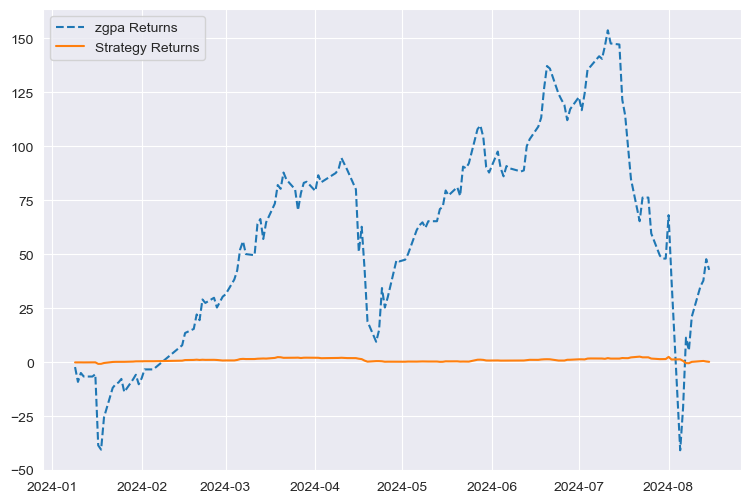

In [153]:
#首先来计算基准收益（预测集）
cum_return = cum_return(df, split_value=len(X_train))
#然后是计算使用算法交易带来的收益（同样只计算预测集）
cum_strategy_return = strategy_return(df, 
                                      split_value=len(X_train))
#用图像来进行对比
plot_chart(cum_return, cum_strategy_return, 'zgpa')
